# 1. DATA COLLECTION #

In [ ]:
import requests
import pandas as pd
import time

# Upbit & Bithumb API URLs
UPBIT_TRADE_URL = "https://api.upbit.com/v1/trades/ticks"
BITHUMB_TRADE_URL = "https://api.bithumb.com/public/transaction_history/"

# 거래 데이터 저장 리스트
trade_data = []

# 요청할 마켓 리스트 (전체 코인 데이터 수집)
UPBIT_MARKETS = []  # 모든 마켓을 동적으로 가져오기 위해 빈 리스트 설정
BITHUMB_MARKETS = []

# Upbit 전체 마켓 리스트 가져오기
def fetch_upbit_markets():
    global UPBIT_MARKETS
    try:
        response = requests.get("https://api.upbit.com/v1/market/all")
        data = response.json()
        UPBIT_MARKETS = [market["market"] for market in data if market["market"].startswith("KRW-")]
    except Exception as e:
        print(f"Error fetching Upbit markets: {e}")

# Bithumb 전체 마켓 리스트 가져오기
def fetch_bithumb_markets():
    global BITHUMB_MARKETS
    try:
        response = requests.get("https://api.bithumb.com/public/ticker/ALL_KRW")
        data = response.json()
        if data["status"] == "0000":
            BITHUMB_MARKETS = list(data["data"].keys())
    except Exception as e:
        print(f"Error fetching Bithumb markets: {e}")

# 데이터 수집 기간 설정 (최근 3개월)
DAYS_TO_COLLECT = 90

# Upbit 데이터 수집 함수
def fetch_upbit_trades(market):
    try:
        params = {"market": market, "count": 200}  # 최대 200개 데이터 요청 가능
        response = requests.get(UPBIT_TRADE_URL, params=params)
        data = response.json()
        
        # API 응답 구조 확인 (디버깅)
        print(f"Upbit API Response for {market}: ", data[:5])  # 처음 5개 데이터 출력
        
        # 데이터가 리스트 형태인지 확인 후 처리
        if isinstance(data, list):  
            for trade in data:
                trade_data.append({
                    "exchange": "Upbit",
                    "market": market,
                    "timestamp": trade.get("timestamp", None),  # 안전한 접근
                    "price": trade.get("trade_price", 0),
                    "volume": trade.get("trade_volume", 0),
                    "trade_amount": trade.get("trade_price", 0) * trade.get("trade_volume", 0)
                })
        else:
            print(f"Unexpected Upbit API response format: {data}")  # 오류 출력

    except Exception as e:
        print(f"Error fetching Upbit trades: {e}")


# Bithumb 데이터 수집 함수
def fetch_bithumb_trades(market):
    try:
        response = requests.get(f"{BITHUMB_TRADE_URL}{market}_KRW")
        data = response.json()
        if data["status"] == "0000":
            for trade in data["data"]:
                trade_data.append({
                    "exchange": "Bithumb",
                    "market": market,
                    "timestamp": trade["transaction_date"],
                    "price": float(trade["price"]),
                    "volume": float(trade["units_traded"]),
                    "trade_amount": float(trade["price"]) * float(trade["units_traded"])
                })
    except Exception as e:
        print(f"Error fetching Bithumb trades: {e}")

# 3개월치 데이터 수집
def collect_trade_data():
    fetch_upbit_markets()
    fetch_bithumb_markets()
    
    for day in range(DAYS_TO_COLLECT):
        print(f"Collecting data for day {day + 1}...")
        for market in UPBIT_MARKETS:
            fetch_upbit_trades(market)
        for market in BITHUMB_MARKETS:
            fetch_bithumb_trades(market)
        time.sleep(1)  # API 요청 제한 방지

# 데이터 수집 실행
collect_trade_data()

# Pandas DataFrame 변환
df = pd.DataFrame(trade_data)

# 거래 금액 기준 상위 10% 임계값 계산
threshold = df["trade_amount"].quantile(0.9)
print(f"Top 10% 거래 금액 임계값: {threshold:.2f} KRW")

# 상위 10% 거래만 필터링
vip_trades = df[df["trade_amount"] >= threshold]

# 결과 저장 (예: CSV 파일)
vip_trades.to_csv("vip_trades.csv", index=False)
print("✅ VIP 거래 데이터 저장 완료!")


Upbit API Response for KRW-BTC:  [{'market': 'KRW-BTC', 'trade_date_utc': '2025-03-19', 'trade_time_utc': '10:41:00', 'timestamp': 1742380860055, 'trade_price': 122671000.0, 'trade_volume': 0.00069332, 'prev_closing_price': 121272000.0, 'change_price': 1399000.0, 'ask_bid': 'ASK', 'sequential_id': 17423808600550011}, {'market': 'KRW-BTC', 'trade_date_utc': '2025-03-19', 'trade_time_utc': '10:41:00', 'timestamp': 1742380860055, 'trade_price': 122671000.0, 'trade_volume': 8.151e-05, 'prev_closing_price': 121272000.0, 'change_price': 1399000.0, 'ask_bid': 'ASK', 'sequential_id': 17423808600550010}, {'market': 'KRW-BTC', 'trade_date_utc': '2025-03-19', 'trade_time_utc': '10:41:00', 'timestamp': 1742380860055, 'trade_price': 122671000.0, 'trade_volume': 0.00815188, 'prev_closing_price': 121272000.0, 'change_price': 1399000.0, 'ask_bid': 'ASK', 'sequential_id': 17423808600550009}, {'market': 'KRW-BTC', 'trade_date_utc': '2025-03-19', 'trade_time_utc': '10:41:00', 'timestamp': 1742380860055, 

# 2. DB (POSTGRESQL) 테이블 생성 및 저장 #

In [5]:
import psycopg2
import pandas as pd

# PostgreSQL 연결 정보
DB_HOST = "localhost"
DB_NAME = "vip"
DB_USER = "postgres"
DB_PASSWORD = "0224"
DB_PORT = "5432" 

# CSV 파일 경로
CSV_FILE = "vip_trades.csv"

# PostgreSQL 테이블 생성 쿼리
CREATE_TABLE_QUERY = """
CREATE TABLE IF NOT EXISTS vip_trades (
    id SERIAL PRIMARY KEY,
    exchange TEXT,
    market TEXT,
    timestamp TIMESTAMP,
    price NUMERIC,
    volume NUMERIC,
    trade_amount NUMERIC
);
"""

# PostgreSQL 연결 및 데이터 삽입
try:
    # DB 연결
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    cursor = conn.cursor()
    
    # 테이블 생성
    cursor.execute(CREATE_TABLE_QUERY)
    conn.commit()
    print("✅ 테이블 생성 완료!")
    
    # CSV 데이터 로드
    df = pd.read_csv(CSV_FILE)

    # timestamp 컬럼이 문자열인지, 숫자인지 확인 후 변환 처리
    def convert_timestamp(value):
        try:
            # 값이 숫자형이면 밀리초(ms) 단위를 초(second)로 변환 후 datetime 변환
            if isinstance(value, (int, float)) and value > 1e10:  # 밀리초 단위라면
                return pd.to_datetime(value / 1000, unit="s")
            # 값이 이미 문자열(datetime 형식)이라면 변환 없이 그대로 반환
            elif isinstance(value, str):
                return pd.to_datetime(value)
        except Exception:
            return None  # 변환 실패 시 None 처리 (PostgreSQL에서 NULL로 처리됨)

    # timestamp 변환 적용
    df["timestamp"] = df["timestamp"].apply(convert_timestamp)

    # NaT 값을 None으로 변환하여 PostgreSQL에 NULL로 삽입되도록 처리
    df["timestamp"] = df["timestamp"].where(df["timestamp"].notnull(), None)

    # 데이터 삽입 쿼리
    INSERT_QUERY = """
    INSERT INTO vip_trades (exchange, market, timestamp, price, volume, trade_amount)
    VALUES (%s, %s, %s, %s, %s, %s)
    """
    
    # 데이터 삽입 실행
    for _, row in df.iterrows():
        cursor.execute(INSERT_QUERY, (
            row["exchange"], row["market"], row["timestamp"] if pd.notna(row["timestamp"]) else None,
            row["price"], row["volume"], row["trade_amount"]
    ))
    
    # 커밋 및 종료
    conn.commit()
    cursor.close()
    conn.close()
    print("✅ CSV 데이터 PostgreSQL에 업로드 완료!")

except Exception as e:
    print(f"❌ 오류 발생: {e}")


✅ 테이블 생성 완료!
✅ CSV 데이터 PostgreSQL에 업로드 완료!


# 3. 데이터 탐색 

In [6]:
# 전체 데이터 개수 확인
total_data_count = df.shape[0]
total_data_count

234698

# 4. Clustering 활용 VIP 고객 분류

## 4-1 Clustering
- 변수 'average coin price'(평균 거래 자산 금액) 'trade_amount' (거래 금액)

In [10]:
import psycopg2
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# PostgreSQL 연결 정보
DB_HOST = "localhost"
DB_NAME = "vip"
DB_USER = "postgres"
DB_PASSWORD = "0224"
DB_PORT = "5432"

# ✅ PostgreSQL에서 데이터 가져오기 (id 포함)
def fetch_vip_trades():
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    query = """
    SELECT id, exchange, market, price, trade_amount
    FROM vip_trades
    """
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# ✅ 데이터 불러오기
df = fetch_vip_trades()

# ✅ 평균 코인가격 계산
df["avg_coin_price"] = df["trade_amount"] / df["price"]
df.dropna(subset=["avg_coin_price"], inplace=True)  # NaN 값 제거

# ✅ 클러스터링에 사용할 변수 선택 (volume 제거)
features = ["trade_amount", "avg_coin_price"]

# ✅ 정규화 적용
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# ✅ K-Means 클러스터링 실행
n_clusters = 5  # 원하는 클러스터 개수 설정
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled_data)

# ✅ 클러스터별 데이터 개수 확인
print("클러스터별 데이터 개수:")
print(df["cluster"].value_counts())

/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/2243204330.py:26: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



클러스터별 데이터 개수:
cluster
0    214215
2     18212
4      1014
3      1014
1       243
Name: count, dtype: int64


### Cluster 결과 Postgresql 저장

In [50]:
import psycopg2

# PostgreSQL 연결
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    port=DB_PORT
)
cursor = conn.cursor()

# `cluster` 컬럼이 없으면 추가
cursor.execute("ALTER TABLE vip_trades ADD COLUMN IF NOT EXISTS cluster INTEGER;")

conn.commit()
cursor.close()
conn.close()

print("✅ 'cluster' 컬럼이 추가됨 (기존에 없었다면).")


✅ 'cluster' 컬럼이 추가됨 (기존에 없었다면).


In [60]:
def fetch_vip_trades():
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    query = """
    SELECT id, exchange, market, price, volume, trade_amount, cluster
    FROM vip_trades;
    """
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# ✅ SQL에서 다시 `id` 포함하여 불러오기
df = fetch_vip_trades()
print(df.columns)  # 이제 `id`가 포함되어야 함


/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1684/1875860060.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Index(['id', 'exchange', 'market', 'price', 'volume', 'trade_amount',
       'cluster'],
      dtype='object')


In [99]:
# ✅ DB에서 기존 cluster 컬럼 삭제 후 새로운 클러스터 저장
def update_db_with_clusters(df):
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    cursor = conn.cursor()

    # ✅ 기존 cluster 컬럼 삭제
    cursor.execute("ALTER TABLE vip_trades DROP COLUMN IF EXISTS cluster")

    # ✅ 새로운 cluster 컬럼 추가
    cursor.execute("ALTER TABLE vip_trades ADD COLUMN cluster INTEGER")

    # ✅ 새로운 클러스터링 결과 업데이트
    for index, row in df.iterrows():
        cursor.execute(
            "UPDATE vip_trades SET cluster = %s WHERE id = %s;",
            (row["cluster"], row["id"])
        )

    conn.commit()
    cursor.close()
    conn.close()
    print("✅ 새로운 클러스터링 결과가 DB에 저장되었습니다!")

# ✅ DB 업데이트 실행
update_db_with_clusters(df)
#기존 clustering 에서 volume 변수 포함해 클러스터링 결과 volume = 1 인 거래들로 인해 클러스터링 분포가 너무 한 개의 클러스터로 편향되어 제외함 (새로운 클러스터링인 이유)

✅ 새로운 클러스터링 결과가 DB에 저장되었습니다!


## 4-2 Cluster 특징 파악 

In [105]:
summary_stats = df.groupby("cluster").agg(
    avg_trade_amount=("trade_amount", "mean"),
    median_trade_amount=("trade_amount", "median"),
    min_trade_amount=("trade_amount", "min"),
    max_trade_amount=("trade_amount", "max"),
    avg_coin_price=("avg_coin_price", "mean"),
    median_coin_price=("avg_coin_price", "median"),
).reset_index()

print(summary_stats)


   cluster  avg_trade_amount  median_trade_amount  min_trade_amount  \
0        0      2.820892e+06         2.325720e+06      1.411629e+06   
1        1      4.753366e+06         2.052044e+06      1.447935e+06   
2        2      1.257220e+07         1.048193e+07      7.662805e+06   
3        3      8.263855e+06         6.479379e+06      4.165315e+06   
4        4      5.568992e+07         4.768200e+07      3.413989e+07   

   max_trade_amount  avg_coin_price  median_coin_price  
0      7.688802e+06    3.876429e+06       4.995747e+03  
1      4.493095e+07    2.103874e+09       1.768375e+09  
2      3.406000e+07    9.486439e+06       9.696331e+03  
3      6.695838e+07    7.818449e+09       6.942191e+09  
4      3.259171e+08    1.782568e+05       5.246489e+03  


/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/725417664.py:26: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



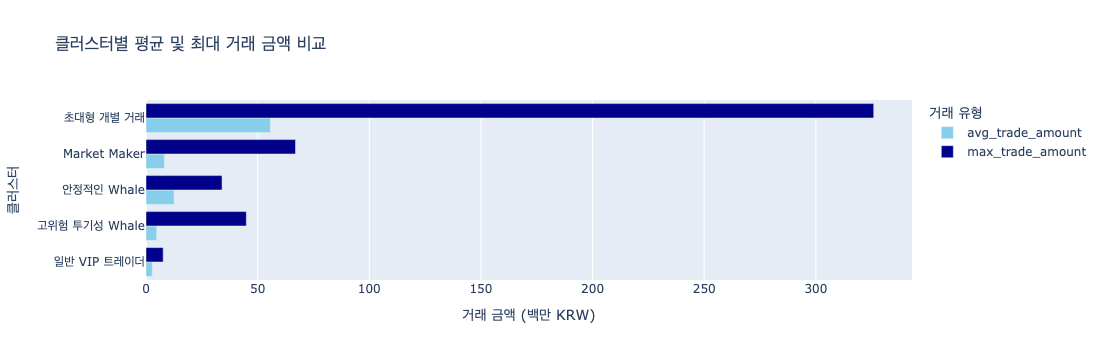

In [56]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password" : "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (클러스터별 평균 및 최대 거래 금액)
query_bar_chart = """
SELECT 
    cluster, 
    AVG(trade_amount) AS avg_trade_amount, 
    MAX(trade_amount) AS max_trade_amount
FROM vip_trades
GROUP BY cluster;
"""
df_bar_chart = pd.read_sql(query_bar_chart, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}
df_bar_chart["cluster_label"] = df_bar_chart["cluster"].map(cluster_labels)

# 🚀 거래 금액 단위를 "백만 KRW"로 변환
df_bar_chart["avg_trade_amount"] = df_bar_chart["avg_trade_amount"] / 1e6
df_bar_chart["max_trade_amount"] = df_bar_chart["max_trade_amount"] / 1e6

# 데이터 변환 (Long Format → Plotly에서 Grouped Bar Chart 지원)
df_melted = df_bar_chart.melt(id_vars=["cluster", "cluster_label"], 
                              value_vars=["avg_trade_amount", "max_trade_amount"],
                              var_name="trade_type", value_name="trade_amount")

# 🚀 Bar Chart 생성 (수평 바 차트로 가독성 향상)
fig_bar_chart = px.bar(
    df_melted,
    x="trade_amount",
    y="cluster_label",
    color="trade_type",
    orientation="h",
    color_discrete_map={"avg_trade_amount": "skyblue", "max_trade_amount": "darkblue"},
    labels={"trade_amount": "거래 금액 (백만 KRW)", "cluster_label": "클러스터", "trade_type": "거래 유형"},
    title="클러스터별 평균 및 최대 거래 금액 비교",
    barmode="group",  # 평균 & 최대를 나란히 비교
    height=500
)

# 시각화 출력
fig_bar_chart.show()


## 4-3 Cluster 별 주요 코인 분석

In [44]:
top_coins_by_cluster = df.groupby(["cluster", "market"])["trade_amount"].sum().reset_index()
top_coins_by_cluster = top_coins_by_cluster.sort_values(["cluster", "trade_amount"], ascending=[True, False])

print(top_coins_by_cluster.groupby("cluster").head(5))  # 클러스터별 TOP 5 코인


     cluster    market  trade_amount
203        0   KRW-ETH  1.221195e+10
250        0   KRW-NEO  1.184131e+10
268        0   KRW-SEI  1.182912e+10
304        0   KRW-XRP  1.134088e+10
202        0   KRW-ETC  8.908845e+09
455        1       NFT  8.039058e+08
454        1   KRW-BTT  6.685440e+08
456        1      PEPE  5.356670e+08
531        2   KRW-DOT  1.310280e+10
621        2   KRW-XRP  1.303198e+10
538        2   KRW-ETH  1.263784e+10
522        2   KRW-BTC  9.932160e+09
612        2  KRW-USDT  6.470794e+09
676        3   KRW-BTT  1.855359e+09
679        3      PEPE  1.840502e+09
677        3  KRW-PEPE  9.416011e+08
680        3      SHIB  1.080180e+08
678        3       NFT  3.939145e+07
685        4   KRW-BTC  1.141780e+10
702        4   KRW-XRP  7.194481e+09
690        4   KRW-ETH  6.999096e+09
700        4  KRW-USDT  6.578457e+09
687        4   KRW-DOT  3.985869e+09


/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/1781602611.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



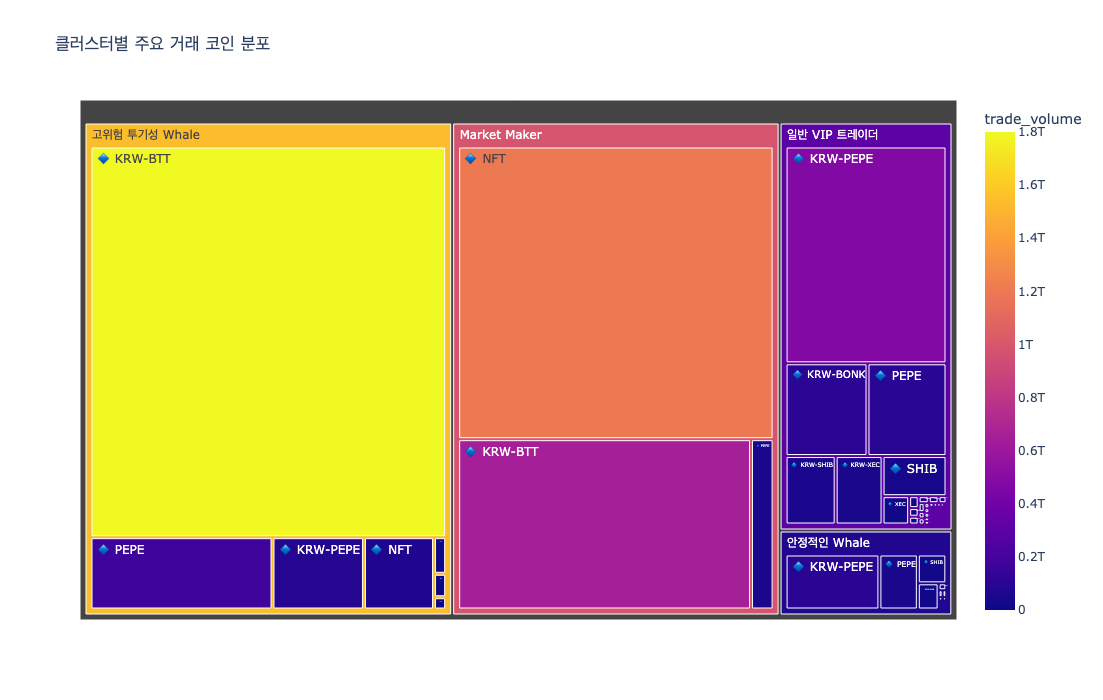

In [66]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password" : "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (클러스터별 주요 거래 코인 및 거래량)
query_treemap = """
SELECT cluster, market AS coin, SUM(volume) AS trade_volume
FROM vip_trades
GROUP BY cluster, market;
"""
df_treemap = pd.read_sql(query_treemap, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}
df_treemap["cluster_label"] = df_treemap["cluster"].map(cluster_labels)

# 🚀 코인명 앞에 심볼 추가 (시각적 가독성 향상)
df_treemap["coin_label"] = df_treemap["coin"].apply(lambda x: f"🔹 {x}")

# 🚀 거래량 기준 정렬 (주요 코인이 위로 정렬)
df_treemap = df_treemap.sort_values(by=["cluster", "trade_volume"], ascending=[True, False])

# Treemap 생성
fig_treemap = px.treemap(
    df_treemap,
    path=["cluster_label", "coin_label"],  # 클러스터명과 코인명 적용
    values="trade_volume",  # 거래량 기준 크기
    color="trade_volume",  # 색상으로 거래량 차이 표현
    color_continuous_scale="Plasma",  # 색상 스타일 변경
    title="클러스터별 주요 거래 코인 분포",
    height=700  # 그래프 크기 조정
)

# 시각화 출력
fig_treemap.show()


## 4-4 거래소 별 클러스터 분포

In [107]:
exchange_distribution = df.groupby(["exchange", "cluster"]).size().unstack(fill_value=0)
print(exchange_distribution)


cluster        0    1      2    3    4
exchange                              
Bithumb    36614  115   3175  151   84
Upbit     177597  899  15038   92  933


/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/2781951872.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



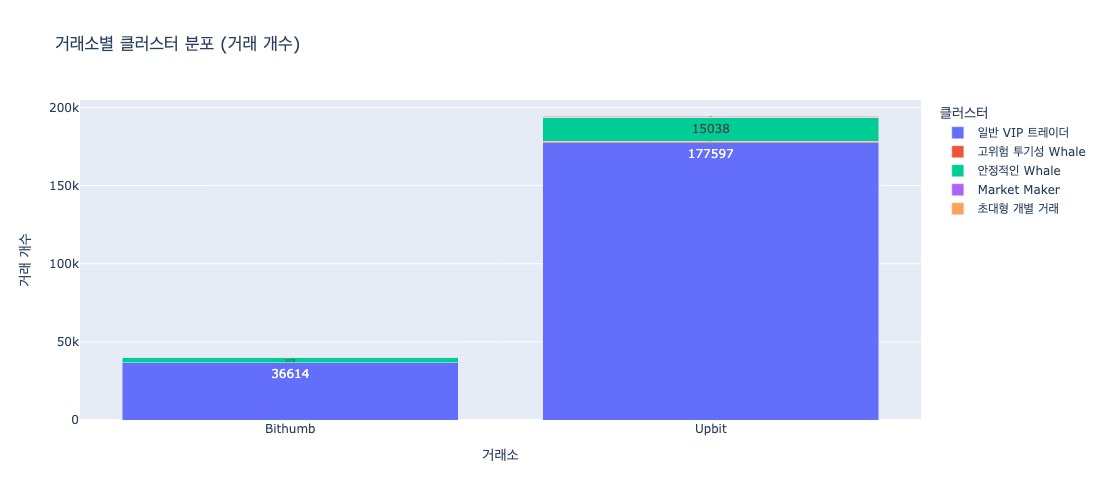

In [71]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password": "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (거래소별 클러스터 거래 개수)
query_cluster_count = """
SELECT exchange, cluster, COUNT(*) AS trade_count
FROM vip_trades
GROUP BY exchange, cluster;
"""
df_cluster_count = pd.read_sql(query_cluster_count, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}
df_cluster_count["cluster_label"] = df_cluster_count["cluster"].map(cluster_labels)

# 🚀 Stacked Bar Chart 생성 (거래 개수 기반 시각화)
fig_cluster_count = px.bar(
    df_cluster_count,
    x="exchange",
    y="trade_count",
    color="cluster_label",
    text=df_cluster_count["trade_count"],  # 막대 위에 거래 개수 표시
    labels={"exchange": "거래소", "trade_count": "거래 개수", "cluster_label": "클러스터"},
    title="거래소별 클러스터 분포 (거래 개수)",
    barmode="stack",
    height=500
)

# 레이아웃 설정 (텍스트 위치 조정)
fig_cluster_count.update_traces(textposition="inside")

# 시각화 출력
fig_cluster_count.show()

/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/698673001.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



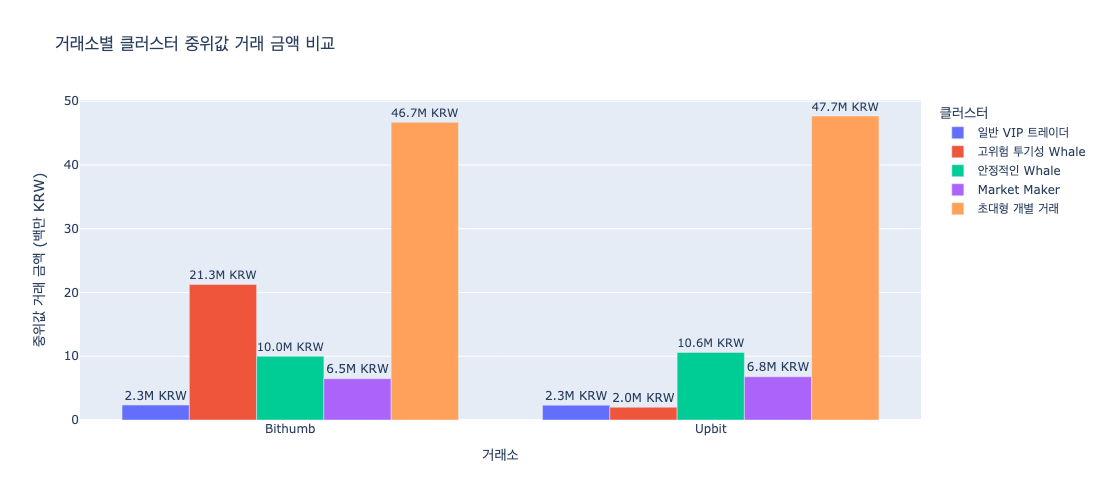

In [68]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password": "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (중위값 거래 금액 계산)
query_median_trade = """
SELECT exchange, cluster, percentile_cont(0.5) WITHIN GROUP (ORDER BY trade_amount) AS median_trade_amount
FROM vip_trades
GROUP BY exchange, cluster;
"""
df_median_trade = pd.read_sql(query_median_trade, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}
df_median_trade["cluster_label"] = df_median_trade["cluster"].map(cluster_labels)

# 🚀 중위값 단위 변환 (백만 KRW 단위)
df_median_trade["median_trade_amount"] = df_median_trade["median_trade_amount"] / 1e6

# 🚀 Bar Chart 생성 (막대 위에 값 표시)
fig_median_trade = px.bar(
    df_median_trade,
    x="exchange",
    y="median_trade_amount",
    color="cluster_label",
    text=df_median_trade["median_trade_amount"].round(1).astype(str) + 'M KRW',  # 막대 위 값 표시
    barmode="group",
    title="거래소별 클러스터 중위값 거래 금액 비교",
    labels={"median_trade_amount": "중위값 거래 금액 (백만 KRW)", "exchange": "거래소", "cluster_label": "클러스터"},
    height=500
)

# 레이아웃 설정 (텍스트 위치 조정)
fig_median_trade.update_traces(textposition="outside")

# 시각화 출력
fig_median_trade.show()


/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/1248890110.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



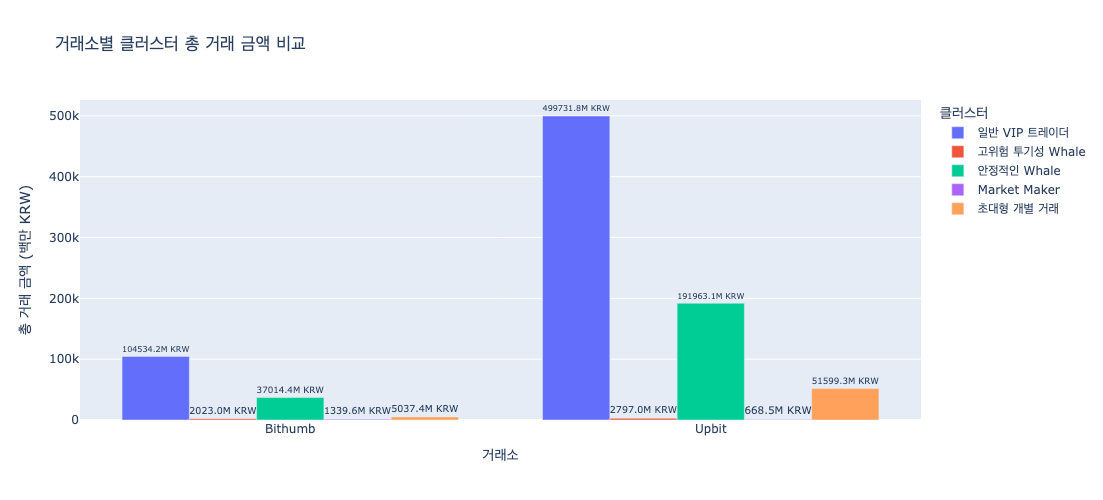

In [72]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password": "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (거래소별 클러스터 총 거래 금액)
query_cluster_amount = """
SELECT exchange, cluster, SUM(trade_amount) AS total_trade_amount
FROM vip_trades
GROUP BY exchange, cluster;
"""
df_cluster_amount = pd.read_sql(query_cluster_amount, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}
df_cluster_amount["cluster_label"] = df_cluster_amount["cluster"].map(cluster_labels)

# 🚀 총 거래 금액 단위 변환 (백만 KRW 단위)
df_cluster_amount["total_trade_amount"] = df_cluster_amount["total_trade_amount"] / 1e6

# 🚀 Bar Chart 생성 (총 거래 금액 기반 시각화)
fig_cluster_amount = px.bar(
    df_cluster_amount,
    x="exchange",
    y="total_trade_amount",
    color="cluster_label",
    text=df_cluster_amount["total_trade_amount"].round(1).astype(str) + 'M KRW',  # 막대 위에 거래 금액 표시
    barmode="group",
    title="거래소별 클러스터 총 거래 금액 비교",
    labels={"total_trade_amount": "총 거래 금액 (백만 KRW)", "exchange": "거래소", "cluster_label": "클러스터"},
    height=500
)

# 레이아웃 설정 (텍스트 위치 조정)
fig_cluster_amount.update_traces(textposition="outside")

# 시각화 출력
fig_cluster_amount.show()

/var/folders/m1/glkd1l_j4_gctd5htcdw_9_h0000gn/T/ipykernel_1665/402025582.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



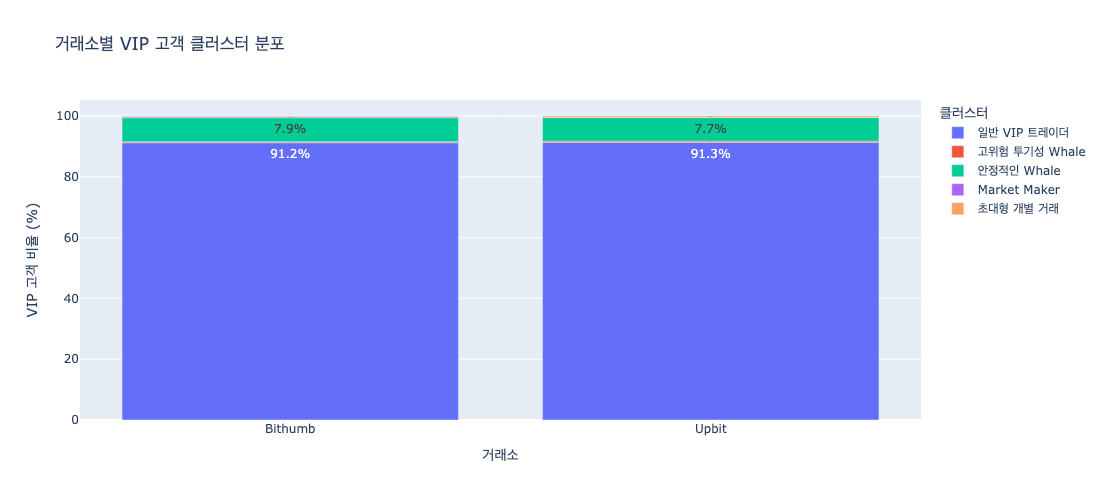

In [65]:
import psycopg2
import pandas as pd
import plotly.express as px

# PostgreSQL 연결 정보
db_params = {
    "dbname": "vip",
    "user": "postgres",
    "password" : "0224",
    "host": "localhost",
    "port": "5432"
}

# DB 연결
conn = psycopg2.connect(**db_params)

# 데이터 불러오기 (거래소별 클러스터 VIP 고객 수)
query_stacked_bar = """
SELECT exchange, cluster, COUNT(DISTINCT id) AS vip_count
FROM vip_trades
GROUP BY exchange, cluster;
"""
df_stacked_bar = pd.read_sql(query_stacked_bar, conn)

# DB 연결 종료
conn.close()

# 🚀 클러스터별 라벨 추가
cluster_labels = {
    0: "일반 VIP 트레이더",
    1: "고위험 투기성 Whale",
    2: "안정적인 Whale",
    3: "Market Maker",
    4: "초대형 개별 거래"
}

# ✅ 클러스터 컬럼이 숫자형(int)인지 확인 (타입 변환 적용)
df_stacked_bar["cluster"] = df_stacked_bar["cluster"].astype(int)

# ✅ 매칭되지 않는 클러스터 값을 처리하여 오류 방지
df_stacked_bar["cluster_label"] = df_stacked_bar["cluster"].map(cluster_labels).fillna("Unknown Cluster")

# 🚀 퍼센트(%) 값 계산 (거래소별 전체 고객 수 대비 클러스터별 비율)
df_stacked_bar["percentage"] = df_stacked_bar["vip_count"] / df_stacked_bar.groupby("exchange")["vip_count"].transform("sum") * 100

# 🚀 Stacked Bar Chart 생성
fig_stacked_bar = px.bar(
    df_stacked_bar,
    x="exchange",
    y="percentage",
    color="cluster_label",
    text=df_stacked_bar["percentage"].round(1).astype(str) + '%',  # 막대 위에 퍼센트 값 표시
    labels={"exchange": "거래소", "percentage": "VIP 고객 비율 (%)", "cluster_label": "클러스터"},
    title="거래소별 VIP 고객 클러스터 분포",
    height=500
)

# 레이아웃 설정 (텍스트 위치 조정)
fig_stacked_bar.update_traces(textposition="inside")

# 시각화 출력
fig_stacked_bar.show()
